# Section 2: Bayesian Inference and PyMC

#### PyData London 2025 - Bayesian Time Series Analysis with PyMC

---

## Statistical Paradigms: Two Ways of Thinking

Before diving into Bayesian methods, it's crucial to understand how Bayesian thinking differs from the traditional frequentist approach.

### Frequentist Worldview

The **frequentist approach** to statistics treats data and parameters in a fundamentally different way than Bayesian methods. In this framework, **data are considered random** because they vary each time we collect them from the same underlying process. Conversely, **parameters are treated as fixed** but unknown constants that we seek to estimate. This leads to the mathematical formulation where we condition on parameters: 

$$\Large P(\text{data} | \text{parameters}) $$

Frequentist inference operates through **point estimators** and **confidence intervals**, where the interpretation of uncertainty relates to the long-run frequency properties of our estimation procedures. A 95% confidence interval, for example, means that if we repeated our sampling procedure many times, 95% of the intervals we construct would contain the true parameter value.

### Bayesian Worldview  

The **Bayesian paradigm** flips this perspective: Here, **data are treated as fixed** once we have observed them—they represent the concrete evidence we have gathered. In contrast, **parameters are treated as random variables** about which we express our uncertainty using probability distributions. This leads to conditioning on the observed data: 

$$\Large P(\text{parameters} | \text{data}) $$

Bayesian inference proceeds through **probability distributions** that directly quantify our uncertainty about parameter values. A Bayesian 95% credible interval has the intuitive interpretation that there is a 95% probability that the parameter lies within that interval, given our data and model assumptions.

This fundamental philosophical difference leads to more **intuitive interpretations** and **natural uncertainty quantification**, making Bayesian methods particularly appealing for time series analysis where we often want to make probabilistic statements about future observations.

---

## Bayes' Theorem: The Foundation

**Bayes' Theorem** is our single tool for learning from data:

$$\huge
\underbrace{\text{Pr}(\theta | y)}_{\textcolor{yellow}{\small \text{Posterior Probability}}}
= 
\frac{
\overbrace{\text{Pr}(y | \theta)}^{\textcolor{yellow}{\small \text{Data Likelihood}}} \cdot
\overbrace{\text{Pr}(\theta)}^{\textcolor{yellow}{\small \text{Prior Probability}}}
}{
\underbrace{\text{Pr}(y)}_{\textcolor{yellow}{\small \text{Normalizing Constant}}}
}
$$

### Breaking Down the Components

- **$P(\theta | y)$** = **Posterior**: What we learn about parameters after seeing data
- **$P(y | \theta)$** = **Likelihood**: How well different parameter values explain our data  
- **$P(\theta)$** = **Prior**: Our initial beliefs about parameters before seeing data
- **$P(y)$** = **Evidence**: Normalizing constant (usually intractable)

### The Learning Process

Bayesian inference is a formal process of **updating beliefs**:

1. **Start** with prior beliefs $P(\theta)$
2. **Observe** data and compute likelihood $P(y | \theta)$
3. **Update** to posterior beliefs $P(\theta | y)$
4. **Repeat** as more data arrives

This makes Bayesian methods naturally suited for time series, where we continuously update our understanding as new observations arrive.

## Prior Specification: Encoding Our Beliefs

One of the most important aspects of Bayesian modeling is **prior specification**. Priors encode our beliefs about parameters before seeing data.

### Types of Priors

The choice of prior distribution represents one of the most important decisions in Bayesian modeling, as it directly influences both the computational efficiency and the interpretability of results. Understanding the different types of priors and their appropriate applications is essential for effective Bayesian analysis.

**Informative priors** incorporate substantial domain knowledge or previous research findings into the analysis. These priors express strong beliefs about parameter values based on external information. For example, if we know from demographic research that birth rates typically range between 10-20 per 1000 people, we might specify `pm.Normal('rate', mu=15, sigma=2)` to encode this knowledge. Informative priors are particularly valuable when working with limited data or when we want to incorporate expert knowledge into our analysis.

**Weakly informative priors** provide gentle regularization without imposing strong constraints on the parameter space. These priors help stabilize the estimation process while allowing the data to largely determine the posterior distribution. A common example is assuming that standardized coefficients usually fall between -3 and 3, leading to a specification like `pm.Normal('coef', mu=0, sigma=1)`. This approach prevents extreme parameter values while remaining relatively non-committal about the exact values.

**Non-informative priors** are designed to let the data dominate the analysis by expressing minimal prior knowledge. These priors attempt to be "objective" by spreading probability mass widely across the parameter space. An example might be `pm.Uniform('param', lower=-100, upper=100)` for a parameter where we have little prior knowledge. However, truly non-informative priors are often difficult to specify and can sometimes lead to computational problems.

### Prior Choice Guidelines

Effective prior specification requires balancing several considerations to ensure both computational stability and meaningful results. **Starting with weakly informative priors** provides an excellent default approach because they offer numerical stability without imposing strong constraints on the analysis. These priors help prevent the sampler from exploring extreme regions of the parameter space that might be computationally problematic.

**Using domain knowledge** when available can significantly improve model performance and interpretability. Subject matter expertise often provides valuable constraints on reasonable parameter ranges, and incorporating this knowledge through informative priors can lead to more realistic and interpretable results.

**Checking prior predictive distributions** serves as a crucial validation step in the modeling process. Before observing any data, we should simulate from our prior distributions to ensure they generate reasonable predictions. If our prior predictive distributions produce implausible results, this indicates that our prior specifications need adjustment.

Finally, **testing sensitivity** to prior choices helps assess the robustness of our conclusions. By fitting the model with different reasonable prior specifications and comparing the results, we can determine how much our conclusions depend on prior assumptions versus the observed data. Substantial sensitivity to prior choice may indicate that we need more data or more carefully considered priors.

In [ ]:
# Import necessary libraries for Section 2
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import warnings

# Configure plotting and suppress warnings
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
warnings.filterwarnings('ignore')

RNG = np.random.default_rng(RANDOM_SEED:=42)

print("🔧 Libraries loaded successfully!")

🔧 Libraries loaded successfully!


In [21]:
# Load preprocessed data from Section 1
# (In practice, you would load this from a saved file or repeat the preprocessing)

# Load births data
births_data = pl.read_csv('../data/births.csv', null_values=['null', 'NA', '', 'NULL'])
births_data = births_data.filter(pl.col('day').is_not_null())

# Aggregate to monthly data
monthly_births = (births_data
    .group_by(['year', 'month'])
    .agg(pl.col('births').sum())
    .sort(['year', 'month'])
)

# Focus on 1970-1990 period
births_subset = (monthly_births
    .filter((pl.col('year') >= 1970) & (pl.col('year') <= 1990))
    .with_row_index('index')
)

# Standardize the data
original_data = births_subset['births'].to_numpy()
births_standardized = (original_data - original_data.mean()) / original_data.std()

print(f"📊 Data loaded: {len(births_standardized)} observations")
print(f"   Standardized data: mean={births_standardized.mean():.3f}, std={births_standardized.std():.3f}")

📊 Data loaded: 228 observations
   Standardized data: mean=-0.000, std=1.000


🔍 **Prior Predictive Check Example - Polynomial Regression**
Before fitting our model, let's check if our priors make sense...


Sampling: [alpha, beta_1, beta_2, prior_pred, sigma]


Prior pred array shape: (1, 1000, 228)
Time idx shape: (228,)
Flattened shape: (1000, 228)


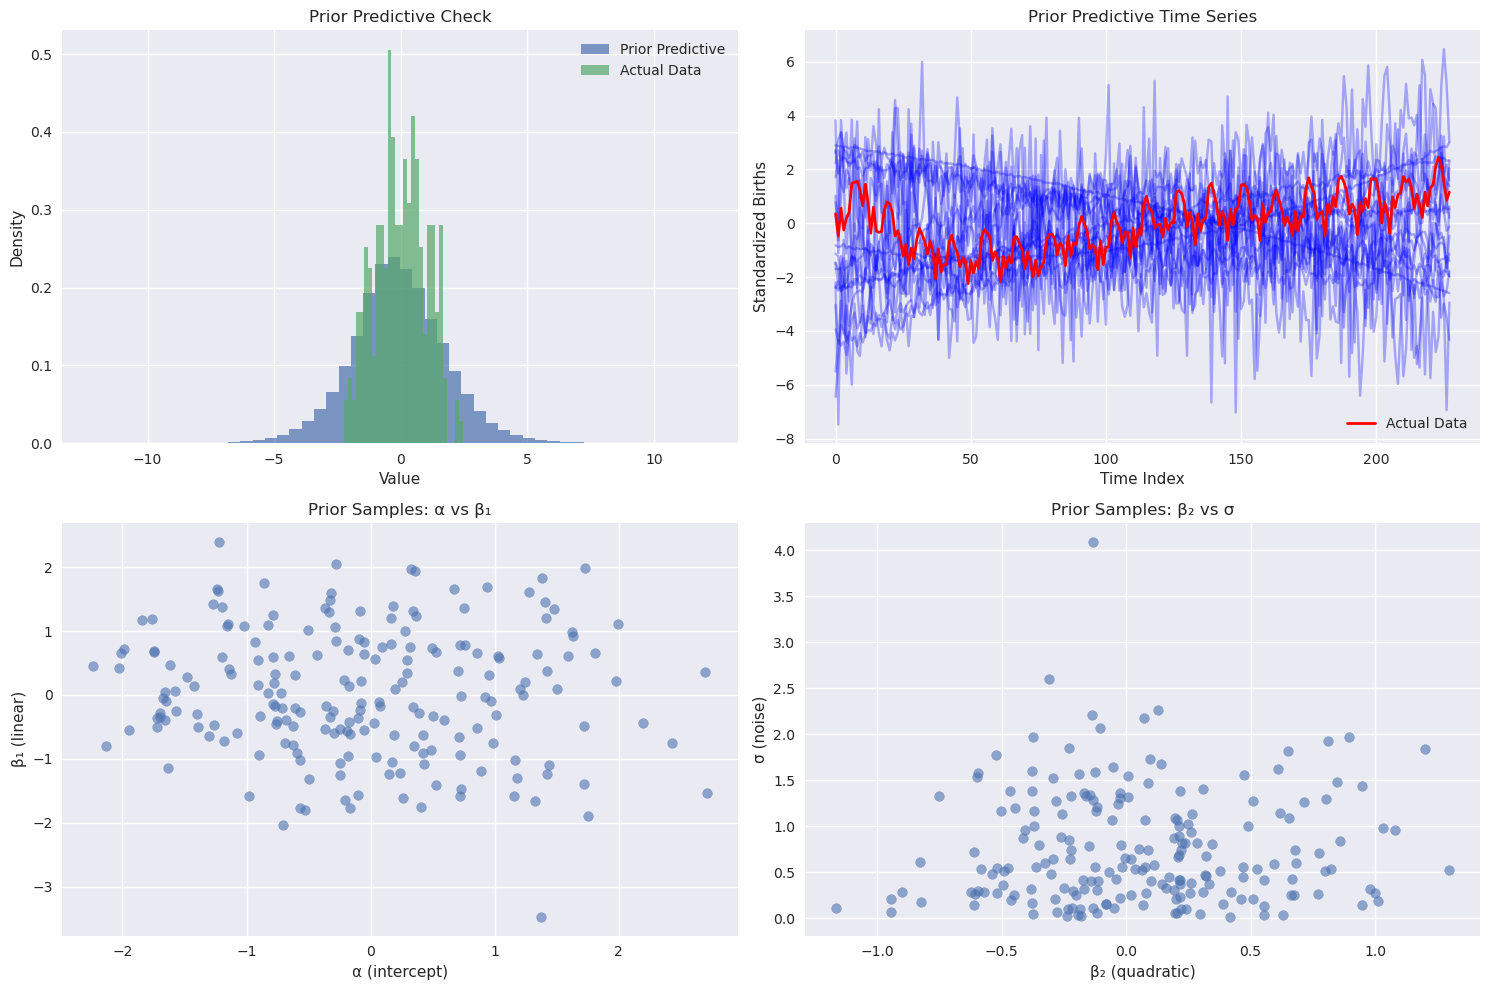


✅ **Prior Check Results**:
   • Prior predictive range: [-12.1, 12.1]
   • Actual data range: [-2.2, 2.4]
   • Coefficient ranges:
     - α (intercept): [-3.02, 3.81]
     - β₁ (linear): [-3.47, 2.93]
     - β₂ (quadratic): [-1.64, 1.78]
   • Our polynomial priors seem reasonable - they allow for various trend shapes!


In [ ]:
# Demonstration: Prior Predictive Checking with Polynomial Regression
print("🔍 **Prior Predictive Check Example - Polynomial Regression**")
print("="*50)
print("Before fitting our model, let's check if our priors make sense...")

# Create time variables for polynomial regression
n_obs = len(births_standardized)
time_idx = np.arange(n_obs)  # Use sequential time indices
time_normalized = (time_idx - time_idx.mean()) / time_idx.std()

print(f"Data characteristics:")
print(f"  • Standardized births: mean={births_standardized.mean():.3f}, std={births_standardized.std():.3f}")
print(f"  • Range: [{births_standardized.min():.2f}, {births_standardized.max():.2f}]")
print(f"  • Time span: {n_obs} months")

# Define a polynomial regression model with realistic priors for time series
with pm.Model(coords={'time': time_idx, 'coef': ['intercept', 'linear', 'quadratic']}) as prior_check_model:
    # More realistic priors for time series data
    # Intercept: should be around 0 (standardized data)
    # Linear: small trend over time
    # Quadratic: very small curvature
    beta = pm.Normal('beta', mu=[0, 0, 0], sigma=[0.5, 0.2, 0.1], dims='coef')
    
    # Create design matrix for polynomial regression
    X = np.column_stack([
        np.ones(n_obs),           # intercept
        time_normalized,          # linear term
        time_normalized**2        # quadratic term
    ])
    
    # Expected value (quadratic polynomial)
    mu_t = pm.Deterministic('mu_t', pm.math.dot(X, beta), dims='time')
    
    # Observation noise - should be reasonable for standardized data
    sigma_prior = pm.HalfNormal('sigma', sigma=0.5)
    
    # What data would these priors generate?
    prior_predictive = pm.Normal('prior_pred', mu=mu_t, sigma=sigma_prior, dims='time')
    
    # Sample from prior predictive
    prior_samples = pm.sample_prior_predictive(samples=500, random_seed=RANDOM_SEED)

# Plot prior predictive samples vs actual data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Prior predictive distribution
prior_pred_samples = prior_samples.prior['prior_pred'].values
ax1.hist(prior_pred_samples.flatten(), bins=50, alpha=0.7, density=True, label='Prior Predictive')
ax1.hist(births_standardized, bins=30, alpha=0.7, density=True, label='Actual Data')
ax1.set_title('Prior Predictive Check')
ax1.set_xlabel('Value')
ax1.set_ylabel('Density')
ax1.legend()

# Time series plot of prior predictive samples
prior_pred_array = prior_samples.prior['prior_pred'].values
print(f"Prior pred array shape: {prior_pred_array.shape}")
print(f"Time idx shape: {time_idx.shape}")

# Handle different possible array structures
if prior_pred_array.ndim == 3:  # (chains, draws, obs)
    # Flatten chains and draws dimensions
    prior_pred_flat = prior_pred_array.reshape(-1, prior_pred_array.shape[-1])
elif prior_pred_array.ndim == 2:  # (draws, obs)
    prior_pred_flat = prior_pred_array
else:
    prior_pred_flat = prior_pred_array.reshape(-1, len(time_idx))

print(f"Flattened shape: {prior_pred_flat.shape}")

for i in range(min(20, prior_pred_flat.shape[0])):
    ax2.plot(time_idx, prior_pred_flat[i], alpha=0.3, color='blue')
ax2.plot(time_idx, births_standardized, color='red', linewidth=2, label='Actual Data')
ax2.set_title('Prior Predictive Time Series')
ax2.set_xlabel('Time Index')
ax2.set_ylabel('Standardized Births')
ax2.legend()

# Prior distributions for coefficients
beta_samples = prior_samples.prior['beta'].values  # Shape: (chains, draws, coef)
# Extract individual coefficients
alpha_samples = beta_samples[:, :, 0].flatten()  # intercept
beta_1_samples = beta_samples[:, :, 1].flatten()  # linear
beta_2_samples = beta_samples[:, :, 2].flatten()  # quadratic
ax3.scatter(alpha_samples[:200], beta_1_samples[:200], alpha=0.6)
ax3.set_xlabel('β₀ (intercept)')
ax3.set_ylabel('β₁ (linear)')
ax3.set_title('Prior Samples: β₀ vs β₁')

# Quadratic coefficient vs sigma
sigma_samples = prior_samples.prior['sigma'].values.flatten()
ax4.scatter(beta_2_samples[:200], sigma_samples[:200], alpha=0.6)
ax4.set_xlabel('β₂ (quadratic)')
ax4.set_ylabel('σ (noise)')
ax4.set_title('Prior Samples: β₂ vs σ')

plt.tight_layout()
plt.show()

## PyMC API and Workflow

PyMC provides a high-level interface for building Bayesian models. The typical workflow involves:

1. **Model Definition**: Specify priors, likelihood, and relationships
2. **Sampling**: Use MCMC to approximate the posterior
3. **Diagnostics**: Check convergence and model fit
4. **Analysis**: Summarize results and make predictions


## Polynomial Regression Model

Now let's implement a more sophisticated model that can capture trends in the data. Instead of assuming a constant mean, we'll use a **polynomial regression** model that can capture linear and quadratic trends over time.

### Model Specification

Our polynomial regression model is:

$$y_t = \mu + \beta_1 \cdot t + \beta_2 \cdot t^2 + \epsilon_t$$

where:
- $\mu$ is the intercept
- $\beta_1$ is the linear trend coefficient
- $\beta_2$ is the quadratic trend coefficient
- $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$ is the observation noise

This model allows us to capture both linear trends and curvature in the time series.

In [ ]:

with pm.Model(coords={'year': years, 'coef': ['linear', 'quadratic']}) as poly_model:

    mu = pm.Normal('mu', mu=0, sigma=1)
    # Vector-valued polynomial regression coefficients with informative priors
    beta = pm.Normal('beta', mu=0, sigma=1, dims='coef')
    
    X = np.column_stack([
        time_normalized,
        time_normalized**2
    ])
    
    # Expected value (quadratic polynomial)
    mu_t = pm.Deterministic('mu_t', mu + pm.math.dot(X, beta), dims='year')
    
    # Observation noise
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu_t, sigma=sigma, observed=births_standardized, dims='year')
    
    # Sample from the posterior
    trace_poly = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, chains=4)

print(az.summary(trace_poly, var_names=['beta', 'sigma']))

Initializing NUTS using jitter+adapt_diag...


🔬 **Polynomial Regression Model**
Now let's fit a polynomial regression model to capture trends in the data.


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.



📊 **Polynomial Model Summary**:
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[linear]     0.576  0.048   0.485    0.665      0.001    0.001    3883.0   
beta[quadratic]  0.399  0.055   0.294    0.498      0.001    0.001    2486.0   
sigma            0.742  0.035   0.676    0.806      0.001    0.001    3560.0   

                 ess_tail  r_hat  
beta[linear]       3085.0    1.0  
beta[quadratic]    2498.0    1.0  
sigma              3192.0    1.0  


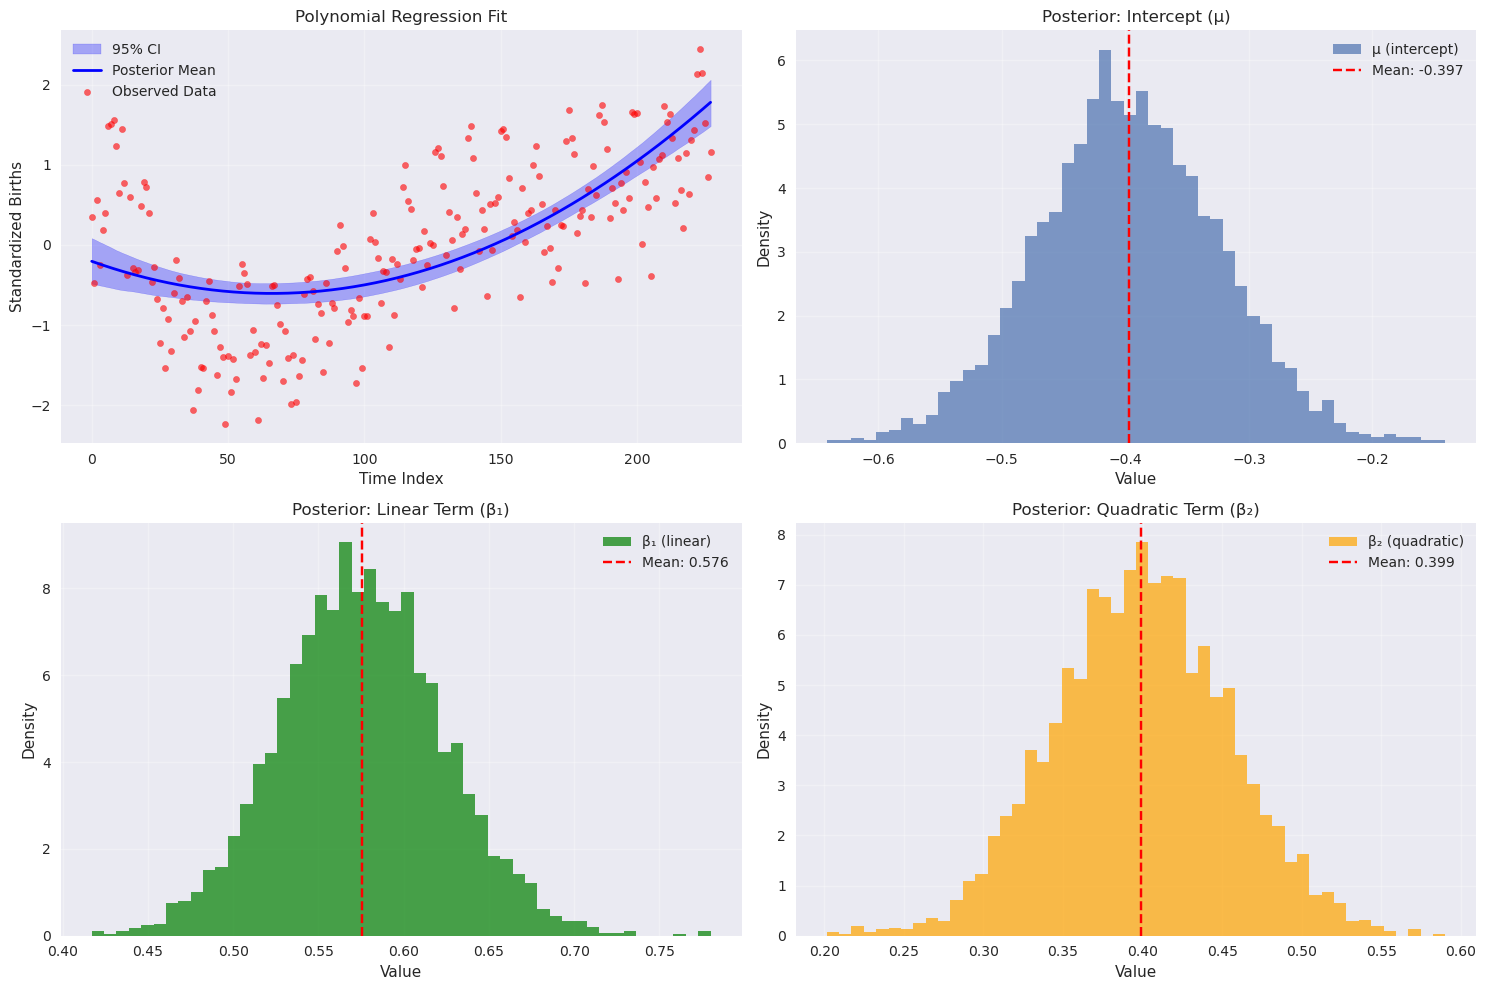

In [61]:
mu_post = trace_poly.posterior['mu'].values.flatten()
beta_1_post = trace_poly.posterior['beta'].sel(coef='linear').values.flatten()
beta_2_post = trace_poly.posterior['beta'].sel(coef='quadratic').values.flatten()
mu_t_post = trace_poly.posterior['mu_t'].values

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

mu_t_reshaped = mu_t_post.reshape(-1, mu_t_post.shape[-1])

mu_mean = np.mean(mu_t_reshaped, axis=0)
mu_lower = np.percentile(mu_t_reshaped, 2.5, axis=0)
mu_upper = np.percentile(mu_t_reshaped, 97.5, axis=0)

ax1.fill_between(time_idx, mu_lower, mu_upper, alpha=0.3, color='blue', label='95% CI')
ax1.plot(time_idx, mu_mean, color='blue', linewidth=2, label='Posterior Mean')
ax1.scatter(time_idx, births_standardized, alpha=0.6, color='red', s=20, label='Observed Data')
ax1.set_title('Polynomial Regression Fit')
ax1.set_xlabel('Time Index')
ax1.set_ylabel('Standardized Births')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.hist(mu_post, bins=50, alpha=0.7, density=True, label='μ (intercept)')
ax2.axvline(np.mean(mu_post), color='red', linestyle='--', label=f'Mean: {np.mean(mu_post):.3f}')
ax2.set_title('Posterior: Intercept (μ)')
ax2.set_xlabel('Value')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3.hist(beta_1_post, bins=50, alpha=0.7, density=True, label='β₁ (linear)', color='green')
ax3.axvline(np.mean(beta_1_post), color='red', linestyle='--', label=f'Mean: {np.mean(beta_1_post):.3f}')
ax3.set_title('Posterior: Linear Term (β₁)')
ax3.set_xlabel('Value')
ax3.set_ylabel('Density')
ax3.legend()
ax3.grid(True, alpha=0.3)

ax4.hist(beta_2_post, bins=50, alpha=0.7, density=True, label='β₂ (quadratic)', color='orange')
ax4.axvline(np.mean(beta_2_post), color='red', linestyle='--', label=f'Mean: {np.mean(beta_2_post):.3f}')
ax4.set_title('Posterior: Quadratic Term (β₂)')
ax4.set_xlabel('Value')
ax4.set_ylabel('Density')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Sampling: [beta, y_obs]


Output()

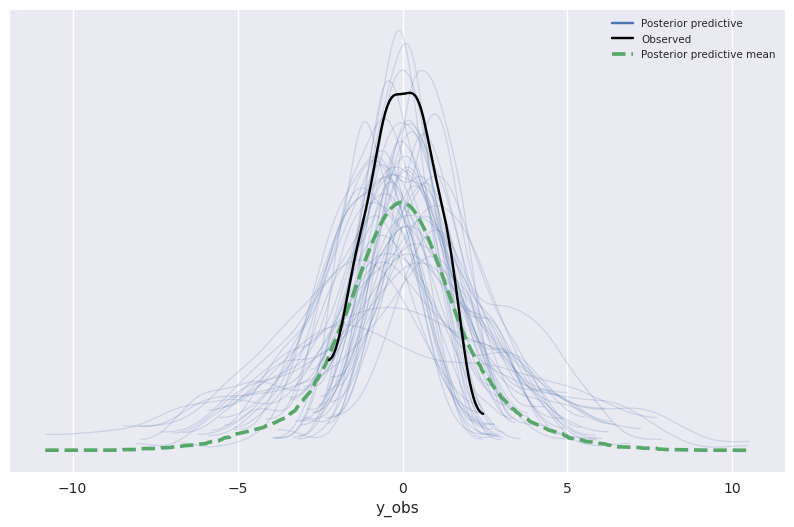

In [62]:
# Posterior predictive checks
with poly_model:
    posterior_predictive = pm.sample_posterior_predictive(trace_basic, random_seed=RANDOM_SEED)

# Plot comparison using ArviZ
az.plot_ppc(posterior_predictive, num_pp_samples=50, figsize=(10, 6))
plt.show()

## Model Diagnostics: Ensuring Reliable Inference

Before trusting our results, we must check that our MCMC sampling worked properly. Poor sampling can lead to incorrect conclusions.

### Key Diagnostic Metrics

1. **R-hat (Gelman-Rubin statistic)**: Measures convergence across chains
   - **Good**: R-hat ≤ 1.01
   - **Acceptable**: R-hat ≤ 1.1  
   - **Poor**: R-hat > 1.1

2. **Effective Sample Size (ESS)**: Number of independent samples
   - **Good**: ESS > 400 (for tail quantities)
   - **Minimum**: ESS > 100

3. **Energy diagnostics**: Check for sampling pathologies
   - **E-BFMI**: Energy Bayesian Fraction of Missing Information
   - **Divergences**: Indicate problematic posterior geometry

🔧 **Model Diagnostics and Convergence Checking**

📊 **Summary Statistics with Diagnostics**:
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[linear]     0.576  0.048   0.485    0.665      0.001    0.001    3883.0   
beta[quadratic]  0.399  0.055   0.294    0.498      0.001    0.001    2486.0   
sigma            0.742  0.035   0.676    0.806      0.001    0.001    3560.0   

                 ess_tail  r_hat  
beta[linear]       3085.0    1.0  
beta[quadratic]    2498.0    1.0  
sigma              3192.0    1.0  

📈 **Trace Plots** (should look like 'fuzzy caterpillars'):


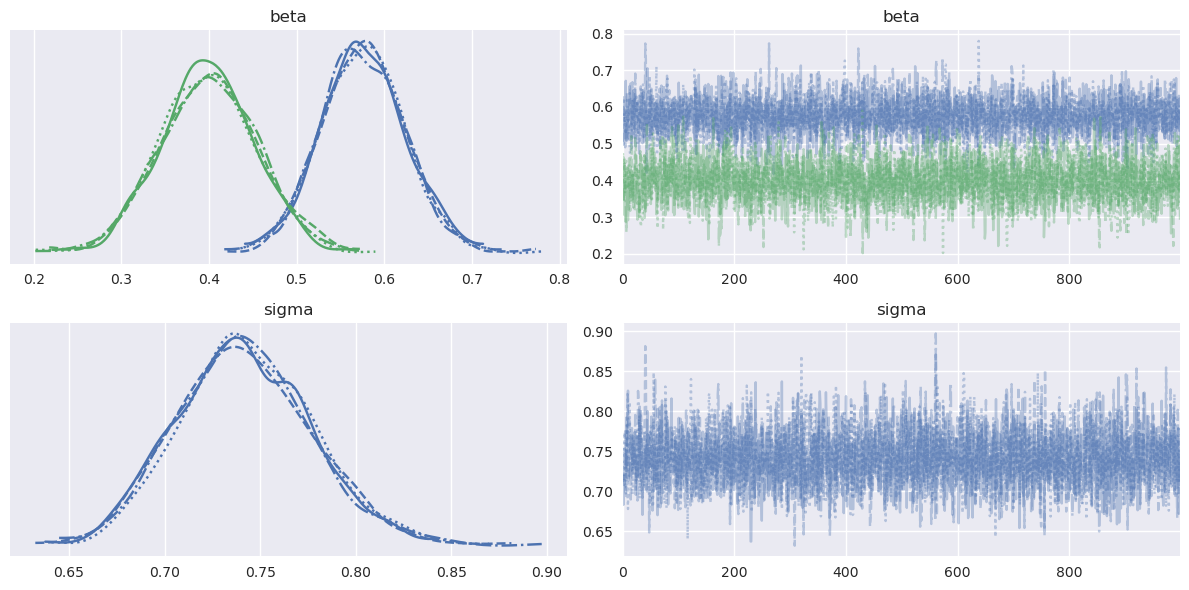


⚠️  **Sampling Diagnostics**:
   • Number of divergences: 0
   • Max tree depth reached: 0 times

⚡ **Energy Diagnostics**:


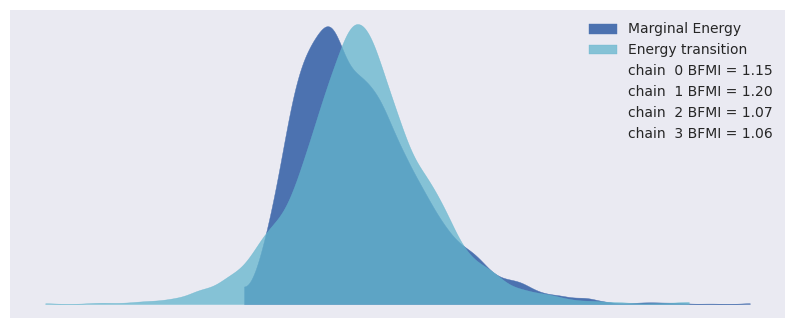


✅ **Diagnostic Interpretation**:
   • R-hat close to 1.0 → Good convergence
   • High ESS → Many effective samples
   • No divergences → Sampling was stable
   • Energy plots overlap → No pathological behavior


In [51]:
# Comprehensive model diagnostics
print("🔧 **Model Diagnostics and Convergence Checking**")
print("="*60)

# Check basic diagnostics
print("\n📊 **Summary Statistics with Diagnostics**:")
summary = az.summary(trace_poly, var_names=['beta', 'sigma'])
print(summary)

# Plot trace plots for visual inspection
print("\n📈 **Trace Plots** (should look like 'fuzzy caterpillars'):")
az.plot_trace(trace_poly, var_names=['beta', 'sigma'], figsize=(12, 6))
plt.tight_layout()
plt.show()

# Check for divergences and other warnings
print("\n⚠️  **Sampling Diagnostics**:")
print(f"   • Number of divergences: {trace_poly.sample_stats.diverging.sum().values}")
print(f"   • Max tree depth reached: {(trace_poly.sample_stats.tree_depth >= 10).sum().values} times")

# Energy plot
print("\n⚡ **Energy Diagnostics**:")
az.plot_energy(trace_poly, figsize=(10, 4))
plt.show()

print("\n✅ **Diagnostic Interpretation**:")
print("   • R-hat close to 1.0 → Good convergence")
print("   • High ESS → Many effective samples")
print("   • No divergences → Sampling was stable")
print("   • Energy plots overlap → No pathological behavior")

## The Complete Bayesian Workflow

Let's summarize the essential steps of Bayesian analysis that we've demonstrated:

### 1. Model Specification
```python
with pm.Model() as model:
    # Priors
    theta = pm.Normal('theta', mu=0, sigma=1)
    # Likelihood  
    obs = pm.Normal('obs', mu=theta, sigma=1, observed=data)
```

### 2. Prior Predictive Checking
```python
prior_pred = pm.sample_prior_predictive(model)
# Check: Do simulated data look reasonable?
```

### 3. Posterior Sampling
```python
trace = pm.sample(model)
```

### 4. Convergence Diagnostics
```python
az.summary(trace)  # Check R-hat, ESS
az.plot_trace(trace)  # Visual inspection
```

### 5. Posterior Predictive Checking
```python
post_pred = pm.sample_posterior_predictive(trace, model)
az.plot_ppc(post_pred)  # Model validation
```

### 6. Inference and Decision Making
```python
# Probability statements
prob_positive = (samples > 0).mean()
# Credible intervals
hdi = az.hdi(samples, hdi_prob=0.95)
```

## Key PyMC Concepts for Time Series

### Important Distributions for Time Series

PyMC provides several distributions specifically designed for time series modeling:

1. **`pm.GaussianRandomWalk`**: For modeling random walk processes
2. **`pm.AR`**: For autoregressive models
3. **`pm.MvGaussianRandomWalk`**: For multivariate random walks
4. **`pm.gp.Marginal`**: For Gaussian process regression

### Model Building Best Practices

Successful Bayesian time series modeling requires following established best practices that ensure both computational reliability and meaningful results. **Starting simple** represents perhaps the most important principle—begin with basic models and add complexity gradually as you understand the data better. This approach helps identify which model components are truly necessary and prevents overfitting.

**Using informative priors** when possible can dramatically improve model performance and interpretability. Domain knowledge about reasonable parameter ranges helps constrain the model and often leads to faster convergence and more stable results. However, it's important to balance informativeness with flexibility to let the data speak.

**Checking convergence** should be a non-negotiable part of every analysis. Always examine R-hat values (should be close to 1.0) and effective sample sizes (should be large relative to the number of parameters) to ensure that your MCMC chains have properly explored the posterior distribution.

**Validating models** through posterior predictive checks and cross-validation helps ensure that your model captures the essential features of your data. A model that fits well but fails to generate realistic predictions is of limited practical value.

Finally, **scaling your data** through standardization or normalization significantly helps with MCMC convergence. Well-scaled data leads to better-conditioned posterior distributions that are easier for sampling algorithms to explore efficiently.

## Summary

In this section, we've established the essential foundations of Bayesian inference and demonstrated how to implement these concepts using PyMC for time series analysis.

### Core Concepts Mastered

We began by exploring the fundamental differences between **statistical paradigms**, contrasting the frequentist and Bayesian worldviews. This philosophical foundation helps us understand why Bayesian methods provide more intuitive interpretations of uncertainty and enable direct probability statements about parameters.

**Bayes' theorem** serves as the mathematical foundation for learning from data, providing the formal mechanism for updating our beliefs as new evidence becomes available. Understanding how the prior, likelihood, and posterior interact is crucial for effective Bayesian modeling.

**Prior specification** represents one of the most important practical skills in Bayesian analysis. We explored how to encode beliefs and domain knowledge through informative, weakly informative, and non-informative priors, along with guidelines for making appropriate choices in different situations.

**MCMC sampling** provides the computational engine that makes modern Bayesian analysis possible. Understanding how algorithms like NUTS approximate complex posterior distributions helps us interpret results and diagnose potential problems.

### Practical Workflow Implementation

We demonstrated the complete Bayesian workflow using **PyMC's API** for model specification and sampling. This hands-on experience with the syntax and structure of PyMC models provides the foundation for building more complex time series models.

**Prior predictive checking** emerged as a crucial validation step that helps ensure our model assumptions are reasonable before observing any data. This practice prevents many common modeling mistakes and builds confidence in our model specifications.

**Convergence diagnostics** provide essential tools for ensuring reliable inference. Learning to interpret R-hat values, effective sample sizes, and trace plots helps us distinguish between trustworthy and problematic results.

**Posterior predictive checking** completes the validation cycle by assessing how well our fitted model can reproduce the patterns in our observed data. This step is essential for model validation and helps identify areas where our model may be inadequate.

**Uncertainty quantification** represents the key advantage of Bayesian methods, enabling us to make probabilistic statements about parameters and predictions that directly support decision-making under uncertainty.

### Time Series Applications

We introduced **specialized distributions** that PyMC provides specifically for temporal modeling, including random walks, autoregressive processes, and Gaussian processes. These tools will be essential for the time series models we build in subsequent sections.

Finally, we established **best practices** for robust Bayesian time series analysis, emphasizing the importance of starting simple, using appropriate priors, checking convergence, validating models, and scaling data properly.

**Next**: In Section 3, we'll apply these foundations to build our first time series-specific models using PyMC's specialized distributions, starting with simple trend models and progressing to more complex seasonal and autoregressive structures.

---

**Key Takeaways**:
- Bayesian thinking provides intuitive probability statements about parameters that directly support decision-making under uncertainty
- The complete Bayesian workflow includes prior and posterior predictive checking along with convergence diagnostics to ensure reliable results
- PyMC combined with ArviZ provides a powerful and user-friendly toolkit for Bayesian time series analysis
- Model checking and validation are essential components of any analysis—never trust results without proper validation
- Uncertainty quantification represents the key advantage of Bayesian methods, enabling better decision-making by explicitly acknowledging and quantifying what we don't know

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w